In [1]:
import pandas as pd
import numpy as np
import sys
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from ms_deisotope import deconvolute_peaks, averagine, scoring
from ms_deisotope.deconvolution import peak_retention_strategy

In [2]:
experiment_base_dir = '/Users/darylwilding-mcbride/Downloads/experiments'
EXPERIMENT_NAME = 'P3856'
RUN_NAME = 'P3856_YHE211_1_Slot1-1_1_5104'

In [3]:
# include points from either side of the intense point
MS2_PEAK_DELTA = 0.1

In [4]:
precursor_id = 25950

In [5]:
CUBOID_DIR = '/Users/darylwilding-mcbride/Downloads/exp-{}-run-{}-precursor-{}-of-52464'.format(EXPERIMENT_NAME, RUN_NAME, precursor_id)
CUBOID_MS2_FILE = '{}/exp-{}-run-{}-precursor-{}-cuboid-points-ms2-df.pkl'.format(CUBOID_DIR, EXPERIMENT_NAME, RUN_NAME, precursor_id)
CUBOID_METADATA_FILE = '{}/exp-{}-run-{}-precursor-{}-cuboid-metadata.json'.format(CUBOID_DIR, EXPERIMENT_NAME, RUN_NAME, precursor_id)

In [6]:
MASS_DEFECT_WINDOW_DA_MIN = 100
MASS_DEFECT_WINDOW_DA_MAX = 5200
PROTON_MASS = 1.007276

In [7]:
ms2_raw_points_df = pd.read_pickle(CUBOID_MS2_FILE)
ms2_raw_points_df['normalised_intensity'] = ms2_raw_points_df.intensity / ms2_raw_points_df.intensity.max()
metadata_s = pd.read_json(CUBOID_METADATA_FILE, orient='records', typ='series')

In [8]:
tableau20 = [(31, 119, 180), (174, 199, 232), (255, 127, 14), (255, 187, 120),  
             (44, 160, 44), (152, 223, 138), (214, 39, 40), (255, 152, 150),  
             (148, 103, 189), (197, 176, 213), (140, 86, 75), (196, 156, 148),  
             (227, 119, 194), (247, 182, 210), (127, 127, 127), (199, 199, 199),  
             (188, 189, 34), (219, 219, 141), (23, 190, 207), (158, 218, 229)]

# Rescale to values between 0 and 1
tableau20_mpl = tableau20.copy()
for i in range(len(tableau20_mpl)):  
    r, g, b = tableau20_mpl[i]  
    tableau20_mpl[i] = (r / 255., g / 255., b / 255.)

In [9]:
# create the bins for mass defect windows in Da space
def generate_mass_defect_windows(mass_defect_window_da_min, mass_defect_window_da_max):
    bin_edges_l = []
    for nominal_mass in range(mass_defect_window_da_min, mass_defect_window_da_max):
        mass_centre = nominal_mass * 1.00048  # from https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3184890/
        width = 0.19 + (0.0001 * nominal_mass)
        lower_mass = mass_centre - (width / 2)
        upper_mass = mass_centre + (width / 2)
        bin_edges_l.append((lower_mass, upper_mass))
    return bin_edges_l

In [10]:
def calculate_mz(mass, charge):
    mz = (mass / charge) + PROTON_MASS
    return mz

In [11]:
# generate the mass defect windows
bins_l = generate_mass_defect_windows(MASS_DEFECT_WINDOW_DA_MIN, MASS_DEFECT_WINDOW_DA_MAX)

In [12]:
charge = 3

In [13]:
# generate the defect windows in m/z for visualisation
bins_mz_l = []
for bin in bins_l:
    mz_lower = calculate_mz(bin[0], charge)
    mz_upper = calculate_mz(bin[1], charge)
    bins_mz_l.append((mz_lower, mz_upper))

In [14]:
# assuming a particular charge, calculate the decharged mass of each ion and remove any that don't sit in a mass defect window
bins = pd.IntervalIndex.from_tuples(bins_l)
ms2_raw_points_df['decharged_mass'] = (ms2_raw_points_df.mz * charge) - (PROTON_MASS * charge)
ms2_raw_points_df['bin'] = pd.cut(ms2_raw_points_df.decharged_mass, bins)

In [15]:
filtered_raw_points_df = ms2_raw_points_df.dropna(subset = ['bin']).copy()
filtered_raw_points_df.drop('bin', axis=1, inplace=True)
filtered_raw_points_df['normalised_intensity'] = filtered_raw_points_df.intensity / filtered_raw_points_df.intensity.max()

In [16]:
removed = len(ms2_raw_points_df) - len(filtered_raw_points_df)
print('removed {} points ({}%)'.format(removed, round(removed/len(ms2_raw_points_df)*100,1)))

removed 40797 points (36.2%)


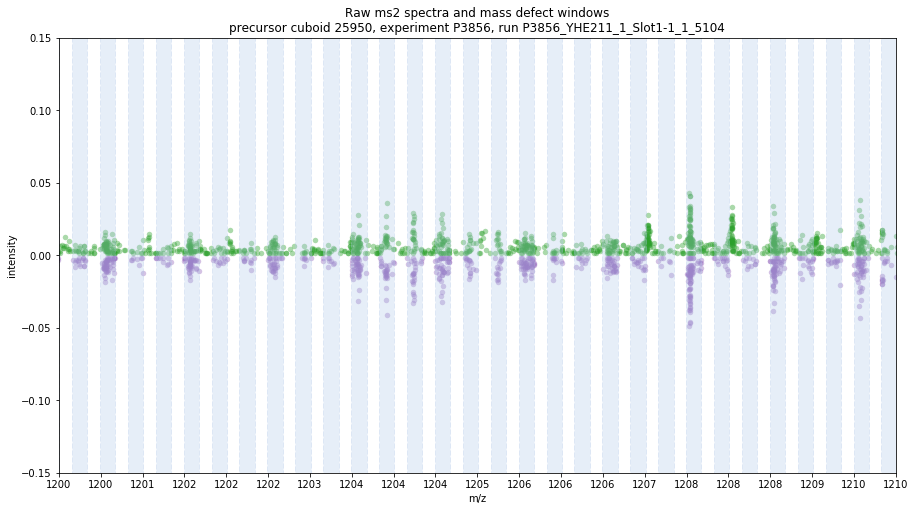

In [17]:
f, ax = plt.subplots()
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan']

# plot the raw data
ax.scatter(ms2_raw_points_df.mz, ms2_raw_points_df.normalised_intensity, marker='o', color='tab:green', lw=0, s=30, alpha=0.4)

# plot the filtered data
ax.scatter(filtered_raw_points_df.mz, -filtered_raw_points_df.normalised_intensity, marker='o', color='tab:purple', lw=0, s=30, alpha=0.4)

for bin in bins_mz_l:
    window_lower_mz = bin[0]
    window_upper_mz = bin[1]
    window_width = window_upper_mz - window_lower_mz
    rect_colour = tableau20_mpl[1]
    rect = patches.Rectangle((window_lower_mz,1.0),window_width,-2.0,linewidth=1,linestyle=(0,(5,2)),edgecolor=rect_colour+(0.3,),facecolor=rect_colour+(0.3,),fill=True)
    ax.add_patch(rect)
    
plt.xlabel('m/z')
plt.ylabel('intensity')
f.set_figheight(8)
f.set_figwidth(15)

nearest = 0.5
range_l = round(ms2_raw_points_df.mz.min() / nearest) * nearest
range_u = round(ms2_raw_points_df.mz.max() / nearest) * nearest
ax.set_xticks(np.arange(range_l,range_u+nearest,nearest))

plt.xlim((1200,1210))
plt.ylim((-0.15,0.15))

plt.margins(0.06)
# plt.legend(loc='best')
plt.title('Raw ms2 spectra and mass defect windows\nprecursor cuboid {}, experiment {}, run {}'.format(precursor_id, EXPERIMENT_NAME, RUN_NAME))
plt.show()

#### intensity descent with and without MDF

In [18]:
# takes a numpy array of intensity, and another of mz
def mz_centroid(_int_f, _mz_f):
    return ((_int_f/_int_f.sum()) * _mz_f).sum()

In [19]:
# peaks_a is a numpy array of [mz,intensity]
# returns a numpy array of [mz_centroid,summed_intensity]
def intensity_descent(peaks_a, peak_delta):
    # intensity descent
    peaks_l = []
    while len(peaks_a) > 0:
        # find the most intense point
        max_intensity_index = np.argmax(peaks_a[:,1])
        peak_mz = peaks_a[max_intensity_index,0]
        peak_mz_lower = peak_mz - peak_delta
        peak_mz_upper = peak_mz + peak_delta

        # get all the raw points within this m/z region
        peak_indexes = np.where((peaks_a[:,0] >= peak_mz_lower) & (peaks_a[:,0] <= peak_mz_upper))[0]
        if len(peak_indexes) > 0:
            mz_cent = mz_centroid(peaks_a[peak_indexes,1], peaks_a[peak_indexes,0])
            summed_intensity = peaks_a[peak_indexes,1].sum()
            peaks_l.append((mz_cent, summed_intensity))
            # remove the raw points assigned to this peak
            peaks_a = np.delete(peaks_a, peak_indexes, axis=0)
    return np.array(peaks_l)

##### without MDF

In [20]:
raw_points_a = ms2_raw_points_df[['mz','intensity']].to_numpy()
peaks_fixed_bins_a = intensity_descent(raw_points_a, MS2_PEAK_DELTA)
peaks_fixed_bins_df = pd.DataFrame(peaks_fixed_bins_a, columns=['mz','intensity'])
peaks_fixed_bins_df['normalised_intensity'] = peaks_fixed_bins_df.intensity / peaks_fixed_bins_df.intensity.max()

In [21]:
print('{} fragment ions, after intensity descent, without MDF'.format(len(peaks_fixed_bins_df)))

7398 fragment ions, after intensity descent, without MDF


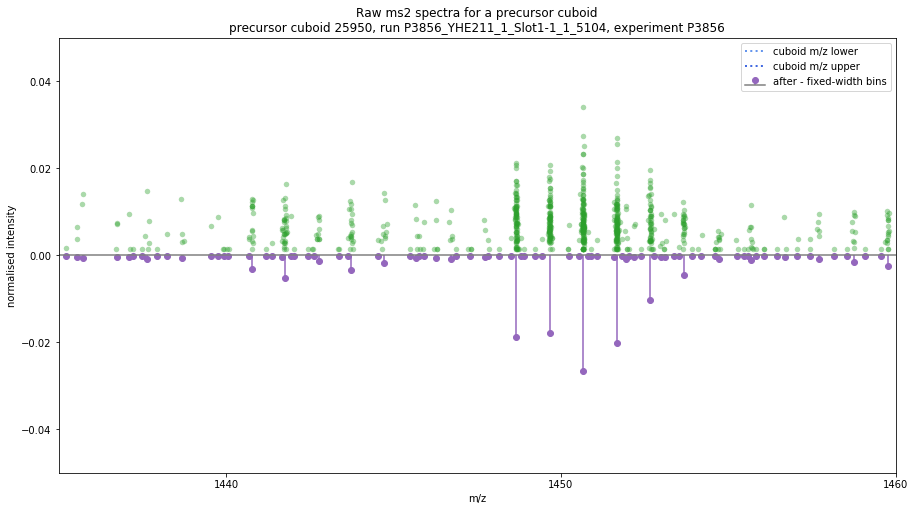

In [22]:
f, ax = plt.subplots()
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan']

ax.scatter(ms2_raw_points_df.mz, ms2_raw_points_df.normalised_intensity, marker='o', color='tab:green', lw=0, s=30, alpha=0.4)

markerline, stemlines, baseline = ax.stem(peaks_fixed_bins_df.mz, -peaks_fixed_bins_df.normalised_intensity, use_line_collection=True, label='after - fixed-width bins')
plt.setp(markerline, 'color', 'tab:purple')
plt.setp(stemlines, 'color', 'tab:purple')
plt.setp(baseline, 'color', 'tab:gray')

plt.axvline(x=metadata_s.window_mz_lower, linestyle=':', color='cornflowerblue', linewidth=2, label='cuboid m/z lower')
plt.axvline(x=metadata_s.window_mz_upper, linestyle=':', color='royalblue', linewidth=2, label='cuboid m/z upper')

plt.xlabel('m/z')
plt.ylabel('normalised intensity')
f.set_figheight(8)
f.set_figwidth(15)

nearest = 10.0
range_l = round(ms2_raw_points_df.mz.min() / nearest) * nearest
range_u = round(ms2_raw_points_df.mz.max() / nearest) * nearest
plt.xticks(np.arange(range_l,range_u+nearest,nearest))

plt.xlim((1435,1460))
plt.ylim((-0.05,0.05))

plt.margins(0.06)
plt.legend(loc='best')
plt.title('Raw ms2 spectra for a precursor cuboid\nprecursor cuboid {}, run {}, experiment {}'.format(precursor_id, RUN_NAME, EXPERIMENT_NAME))
plt.show()

In [23]:
# deconvolute the spectra
peaks_l = list(map(tuple, peaks_fixed_bins_a))
deconvoluted_peaks, _ = deconvolute_peaks(peaks_l, use_quick_charge=True, averagine=averagine.peptide, charge_range=(1,5), scorer=scoring.MSDeconVFitter(minimum_score=8, mass_error_tolerance=0.1), error_tolerance=4e-5, truncate_after=0.8, retention_strategy=peak_retention_strategy.TopNRetentionStrategy(n_peaks=100, base_peak_coefficient=1e-6, max_mass=1800.0))


In [24]:
print('{} deconvoluted ions'.format(len(deconvoluted_peaks)))

1780 deconvoluted ions


In [25]:
# package the spectra as a list
deconvoluted_peaks_l = []
for peak in deconvoluted_peaks:
    deconvoluted_peaks_l.append((precursor_id, round(peak.neutral_mass+PROTON_MASS, 4), int(peak.charge), peak.intensity, peak.score, peak.signal_to_noise))
deconvoluted_peaks_df = pd.DataFrame(deconvoluted_peaks_l, columns=['precursor','mz','charge','intensity','score','SN'])
deconvoluted_peaks_df['normalised_intensity'] = deconvoluted_peaks_df.intensity / deconvoluted_peaks_df.intensity.max()


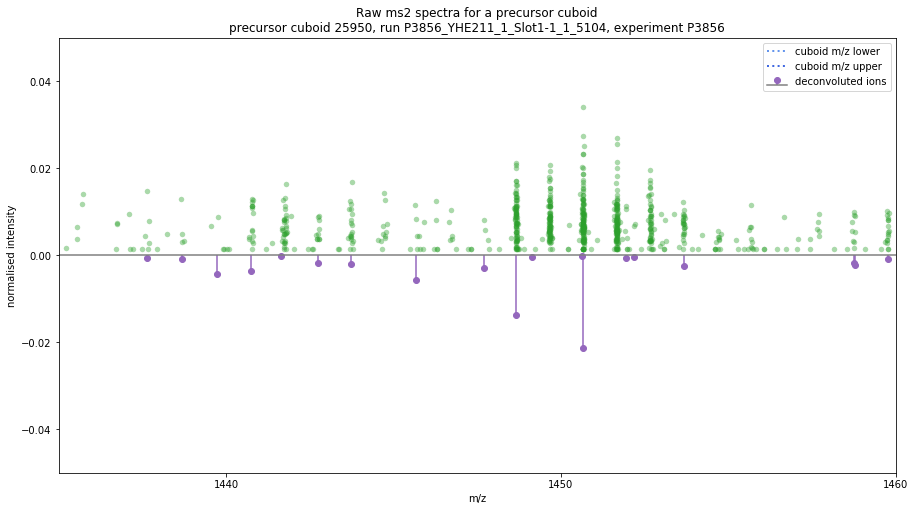

In [26]:
f, ax = plt.subplots()
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan']

ax.scatter(ms2_raw_points_df.mz, ms2_raw_points_df.normalised_intensity, marker='o', color='tab:green', lw=0, s=30, alpha=0.4)

markerline, stemlines, baseline = ax.stem(deconvoluted_peaks_df.mz, -deconvoluted_peaks_df.normalised_intensity, use_line_collection=True, label='deconvoluted ions')
plt.setp(markerline, 'color', 'tab:purple')
plt.setp(stemlines, 'color', 'tab:purple')
plt.setp(baseline, 'color', 'tab:gray')

plt.axvline(x=metadata_s.window_mz_lower, linestyle=':', color='cornflowerblue', linewidth=2, label='cuboid m/z lower')
plt.axvline(x=metadata_s.window_mz_upper, linestyle=':', color='royalblue', linewidth=2, label='cuboid m/z upper')

plt.xlabel('m/z')
plt.ylabel('normalised intensity')
f.set_figheight(8)
f.set_figwidth(15)

nearest = 10.0
range_l = round(ms2_raw_points_df.mz.min() / nearest) * nearest
range_u = round(ms2_raw_points_df.mz.max() / nearest) * nearest
plt.xticks(np.arange(range_l,range_u+nearest,nearest))

plt.xlim((1435,1460))
plt.ylim((-0.05,0.05))

plt.margins(0.06)
plt.legend(loc='best')
plt.title('Raw ms2 spectra for a precursor cuboid\nprecursor cuboid {}, run {}, experiment {}'.format(precursor_id, RUN_NAME, EXPERIMENT_NAME))
plt.show()

##### with MDF

In [27]:
raw_points_a = filtered_raw_points_df[['mz','intensity']].to_numpy()
peaks_fixed_bins_a = intensity_descent(raw_points_a, MS2_PEAK_DELTA)
peaks_fixed_bins_df = pd.DataFrame(peaks_fixed_bins_a, columns=['mz','intensity'])
peaks_fixed_bins_df['normalised_intensity'] = peaks_fixed_bins_df.intensity / peaks_fixed_bins_df.intensity.max()

In [28]:
print('{} resolved ions, after intensity descent, with MDF'.format(len(peaks_fixed_bins_df)))

4278 resolved ions, after intensity descent, with MDF


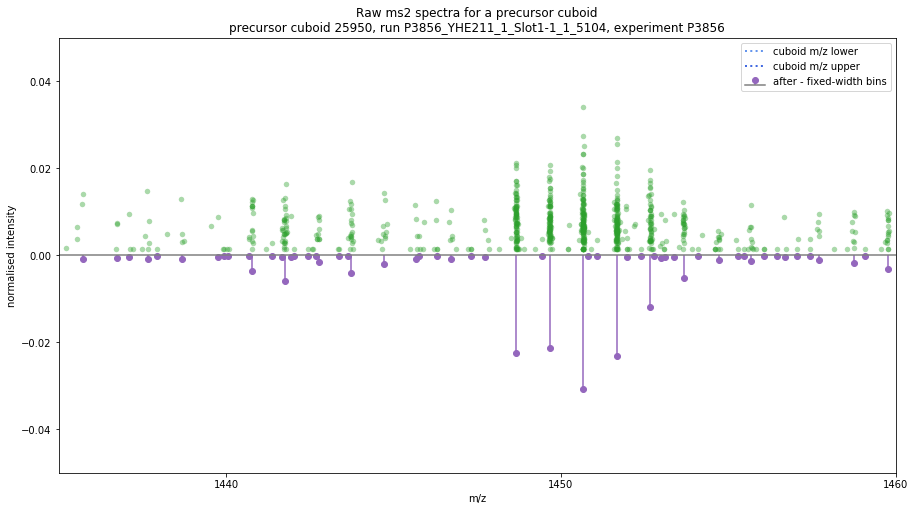

In [29]:
f, ax = plt.subplots()
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan']

ax.scatter(ms2_raw_points_df.mz, ms2_raw_points_df.normalised_intensity, marker='o', color='tab:green', lw=0, s=30, alpha=0.4)

markerline, stemlines, baseline = ax.stem(peaks_fixed_bins_df.mz, -peaks_fixed_bins_df.normalised_intensity, use_line_collection=True, label='after - fixed-width bins')
plt.setp(markerline, 'color', 'tab:purple')
plt.setp(stemlines, 'color', 'tab:purple')
plt.setp(baseline, 'color', 'tab:gray')

plt.axvline(x=metadata_s.window_mz_lower, linestyle=':', color='cornflowerblue', linewidth=2, label='cuboid m/z lower')
plt.axvline(x=metadata_s.window_mz_upper, linestyle=':', color='royalblue', linewidth=2, label='cuboid m/z upper')

plt.xlabel('m/z')
plt.ylabel('normalised intensity')
f.set_figheight(8)
f.set_figwidth(15)

nearest = 10.0
range_l = round(ms2_raw_points_df.mz.min() / nearest) * nearest
range_u = round(ms2_raw_points_df.mz.max() / nearest) * nearest
plt.xticks(np.arange(range_l,range_u+nearest,nearest))

plt.xlim((1435,1460))
plt.ylim((-0.05,0.05))

plt.margins(0.06)
plt.legend(loc='best')
plt.title('Raw ms2 spectra for a precursor cuboid\nprecursor cuboid {}, run {}, experiment {}'.format(precursor_id, RUN_NAME, EXPERIMENT_NAME))
plt.show()

In [30]:
# deconvolute the spectra
peaks_l = list(map(tuple, peaks_fixed_bins_a))
deconvoluted_peaks, _ = deconvolute_peaks(peaks_l, use_quick_charge=True, averagine=averagine.peptide, charge_range=(1,5), scorer=scoring.MSDeconVFitter(minimum_score=8, mass_error_tolerance=0.1), error_tolerance=4e-5, truncate_after=0.8, retention_strategy=peak_retention_strategy.TopNRetentionStrategy(n_peaks=100, base_peak_coefficient=1e-6, max_mass=1800.0))


In [31]:
print('{} deconvoluted ions'.format(len(deconvoluted_peaks)))

1626 deconvoluted ions


In [32]:
# package the spectra as a list
deconvoluted_peaks_l = []
for peak in deconvoluted_peaks:
    deconvoluted_peaks_l.append((precursor_id, round(peak.neutral_mass+PROTON_MASS, 4), int(peak.charge), peak.intensity, peak.score, peak.signal_to_noise))
deconvoluted_peaks_df = pd.DataFrame(deconvoluted_peaks_l, columns=['precursor','mz','charge','intensity','score','SN'])
deconvoluted_peaks_df['normalised_intensity'] = deconvoluted_peaks_df.intensity / deconvoluted_peaks_df.intensity.max()


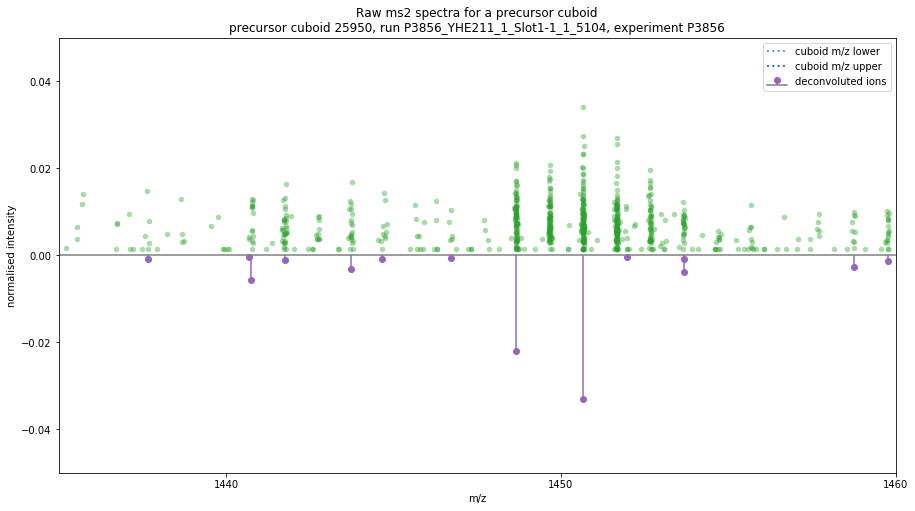

In [33]:
f, ax = plt.subplots()
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan']

ax.scatter(ms2_raw_points_df.mz, ms2_raw_points_df.normalised_intensity, marker='o', color='tab:green', lw=0, s=30, alpha=0.4)

markerline, stemlines, baseline = ax.stem(deconvoluted_peaks_df.mz, -deconvoluted_peaks_df.normalised_intensity, use_line_collection=True, label='deconvoluted ions')
plt.setp(markerline, 'color', 'tab:purple')
plt.setp(stemlines, 'color', 'tab:purple')
plt.setp(baseline, 'color', 'tab:gray')

plt.axvline(x=metadata_s.window_mz_lower, linestyle=':', color='cornflowerblue', linewidth=2, label='cuboid m/z lower')
plt.axvline(x=metadata_s.window_mz_upper, linestyle=':', color='royalblue', linewidth=2, label='cuboid m/z upper')

plt.xlabel('m/z')
plt.ylabel('normalised intensity')
f.set_figheight(8)
f.set_figwidth(15)

nearest = 10.0
range_l = round(ms2_raw_points_df.mz.min() / nearest) * nearest
range_u = round(ms2_raw_points_df.mz.max() / nearest) * nearest
plt.xticks(np.arange(range_l,range_u+nearest,nearest))

plt.xlim((1435,1460))
plt.ylim((-0.05,0.05))

plt.margins(0.06)
plt.legend(loc='best')
plt.title('Raw ms2 spectra for a precursor cuboid\nprecursor cuboid {}, run {}, experiment {}'.format(precursor_id, RUN_NAME, EXPERIMENT_NAME))
plt.show()